In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
import joblib
from scipy.special import softmax
import sasc.config
import numpy as np
from collections import defaultdict
from copy import deepcopy
import pandas as pd
import imodelsx.linear_finetune
from sasc import analyze_helper
from sasc.modules.fmri_module import convert_module_num_to_voxel_num
from sasc.config import FMRI_DIR, RESULTS_DIR
import dvu
dvu.set_style()
story_data = joblib.load(join(sasc.config.RESULTS_DIR, 'pilot2_story_data.pkl'))

In [2]:
# load data and corresponding resps
pilot_data_dir = '/home/chansingh/mntv1/deep-fMRI/story_data/20230702'
# resp_np_files = sorted(os.listdir(pilot_data_dir))
resp_np_files = ['GenStory7.npy', 'GenStory8.npy']
resps_dict = {
    k: np.load(join(pilot_data_dir, k))
    for k in tqdm(resp_np_files)
}

100%|██████████| 2/2 [00:18<00:00,  9.00s/it]


0 GenStory7_resps.npy
story_num=0 len(rows)=16 len(paragraphs)=16 len(resp_chunks)=16


/tmp/ipykernel_3098705/3042420923.py:40: RuntimeWarning: Mean of empty slice
  mat1[:, i] = np.nanmean(resp_chunks[i][voxel_num1], axis=1)
/tmp/ipykernel_3098705/3042420923.py:41: RuntimeWarning: Mean of empty slice
  mat2[:, i] = np.nanmean(resp_chunks[i][voxel_num2], axis=1)


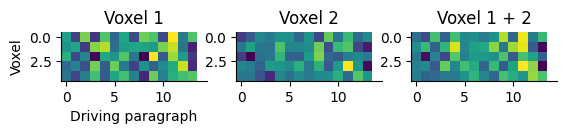

shape (15, 15) (5, 15)


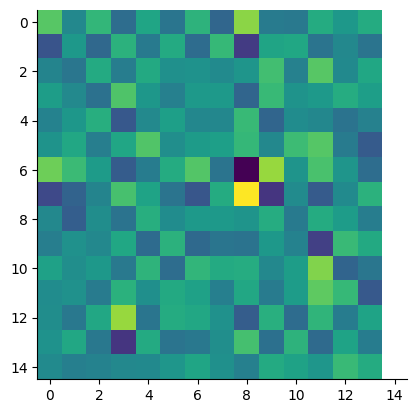

In [60]:
INTERACTION_STORIES = [0]
mats1 = defaultdict(list)
mats2 = defaultdict(list)
for use_clusters in [False]:
    for story_num in INTERACTION_STORIES:
        print(story_num, story_data["story_name_new"][story_num])
        rows = story_data["rows"][story_num]

        # get resp_chunks
        resp_story = resps_dict[
            story_data["story_name_new"][story_num].replace('_resps', '')
        ].T  # (voxels, time)
        timing = story_data["timing"][story_num]
        # paragraphs = story_data["story_text"][story_num].split("\n\n")
        paragraphs = story_data["paragraphs"][story_num]
        # assert len(paragraphs) == len(rows)
        resp_chunks = analyze_helper.get_resp_chunks(timing, paragraphs, resp_story, offset=5)


        print(f'{story_num=} {len(rows)=} {len(paragraphs)=} {len(resp_chunks)=}')
        # print(rows['expl1'])

        # add 0 to the beginning of the voxel_num2
        voxel_num1 = story_data['voxel_num1'][story_num]
        voxel_num2 = story_data['voxel_num2'][story_num]

        # calculate mat (rows has an extra leading row which we ignore)
        mat1 = np.zeros((len(voxel_num1), len(paragraphs)))
        mat2 = np.zeros((len(voxel_num2), len(paragraphs)))
        # fill mat with nans
        # mat[:] = np.nan

        for i in range(len(paragraphs)):
            if i >= len(resp_chunks):
                print('break', i)
                mat1[:, i] = np.nan
                mat2[:, i] = np.nan
                break
            if use_clusters == False:
                mat1[:, i] = np.nanmean(resp_chunks[i][voxel_num1], axis=1)
                mat2[:, i] = np.nanmean(resp_chunks[i][voxel_num2], axis=1)
            # elif use_clusters == True:
            #     for r in range(len(rows)):
            #         cluster_nums = rows.iloc[r]["cluster_nums"]
            #         if isinstance(cluster_nums, np.ndarray):
            #             vals = resp_chunks[i][cluster_nums].flatten()
            #             mat1[r, i] = np.nanmean(vals)
            #         else:
            #             # print(cluster_nums)
            #             mat1[r, i] = np.nan
        mat1 = mat1[:, 1:]  # ignore the first column
        mat2 = mat2[:, 1:]  # ignore the first column

        # mat[:, -1] = np.nan  # ignore the last column
        # print('mat', mat)

        # sort by voxel_num
        # args = np.argsort(rows["voxel_num"].values)
        # mat = mat[args, :][:, args]
        # mat = mat[::2]  # only take even rows (since each row is duplicated)
        mats1[use_clusters].append(deepcopy(mat1))
        mats2[use_clusters].append(deepcopy(mat2))

        plt.subplot(131)
        plt.imshow(mat1)
        plt.xlabel('Driving paragraph')
        plt.ylabel('Voxel')
        plt.title('Voxel 1')
        plt.subplot(132)
        plt.imshow(mat2)
        plt.title('Voxel 2')
        plt.subplot(133)
        plt.title('Voxel 1 + 2')
        mat3 = mat1 + mat2
        plt.imshow(mat3)
        plt.show()

        # select the appropriate columns based on what we are trying to maximize
        mat_out = np.zeros((mat1.shape[0] * 3, mat1.shape[1]))
        print('shape', mat_out.shape, mat1.shape)
        for i in range(0, mat_out.shape[0], 3):
            i3 = i // 3
            mat_out[i] = mat1[i3] - mat2[i3]
            mat_out[i + 1] = mat2[i3] - mat1[i3]
            mat_out[i + 2] = (mat1[i3] + mat2[i3]) / 2
        plt.imshow(mat_out)
        plt.show()


# rows = rows.sort_values(by="voxel_num")
expls = rows["expl"].values


# m = {}
# for use_clusters in [False, True]:
    # mats1[use_clusters] = np.array(mats[use_clusters])  # (num_stories, num_voxels, num_paragraphs)
    # m[use_clusters] = np.nanmean(mats[use_clusters], axis=0)

In [72]:
mat_inter = mat_out[2::3, 2::3]
# remove every third row and column
idxs = np.arange(mat_out.shape[0])
idxs = np.delete(idxs, np.arange(2, mat_out.shape[0], 3))
mat_single = mat_out[idxs, :][:, idxs]

### Make average plot

<>:46: DeprecationWarning: invalid escape sequence '\s'
<>:46: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_3098705/2711371513.py:46: DeprecationWarning: invalid escape sequence '\s'
  plt.ylabel('Mean voxel response ($\sigma_f$)')


mean 0.15571286310117918
median 0.034679725898495495


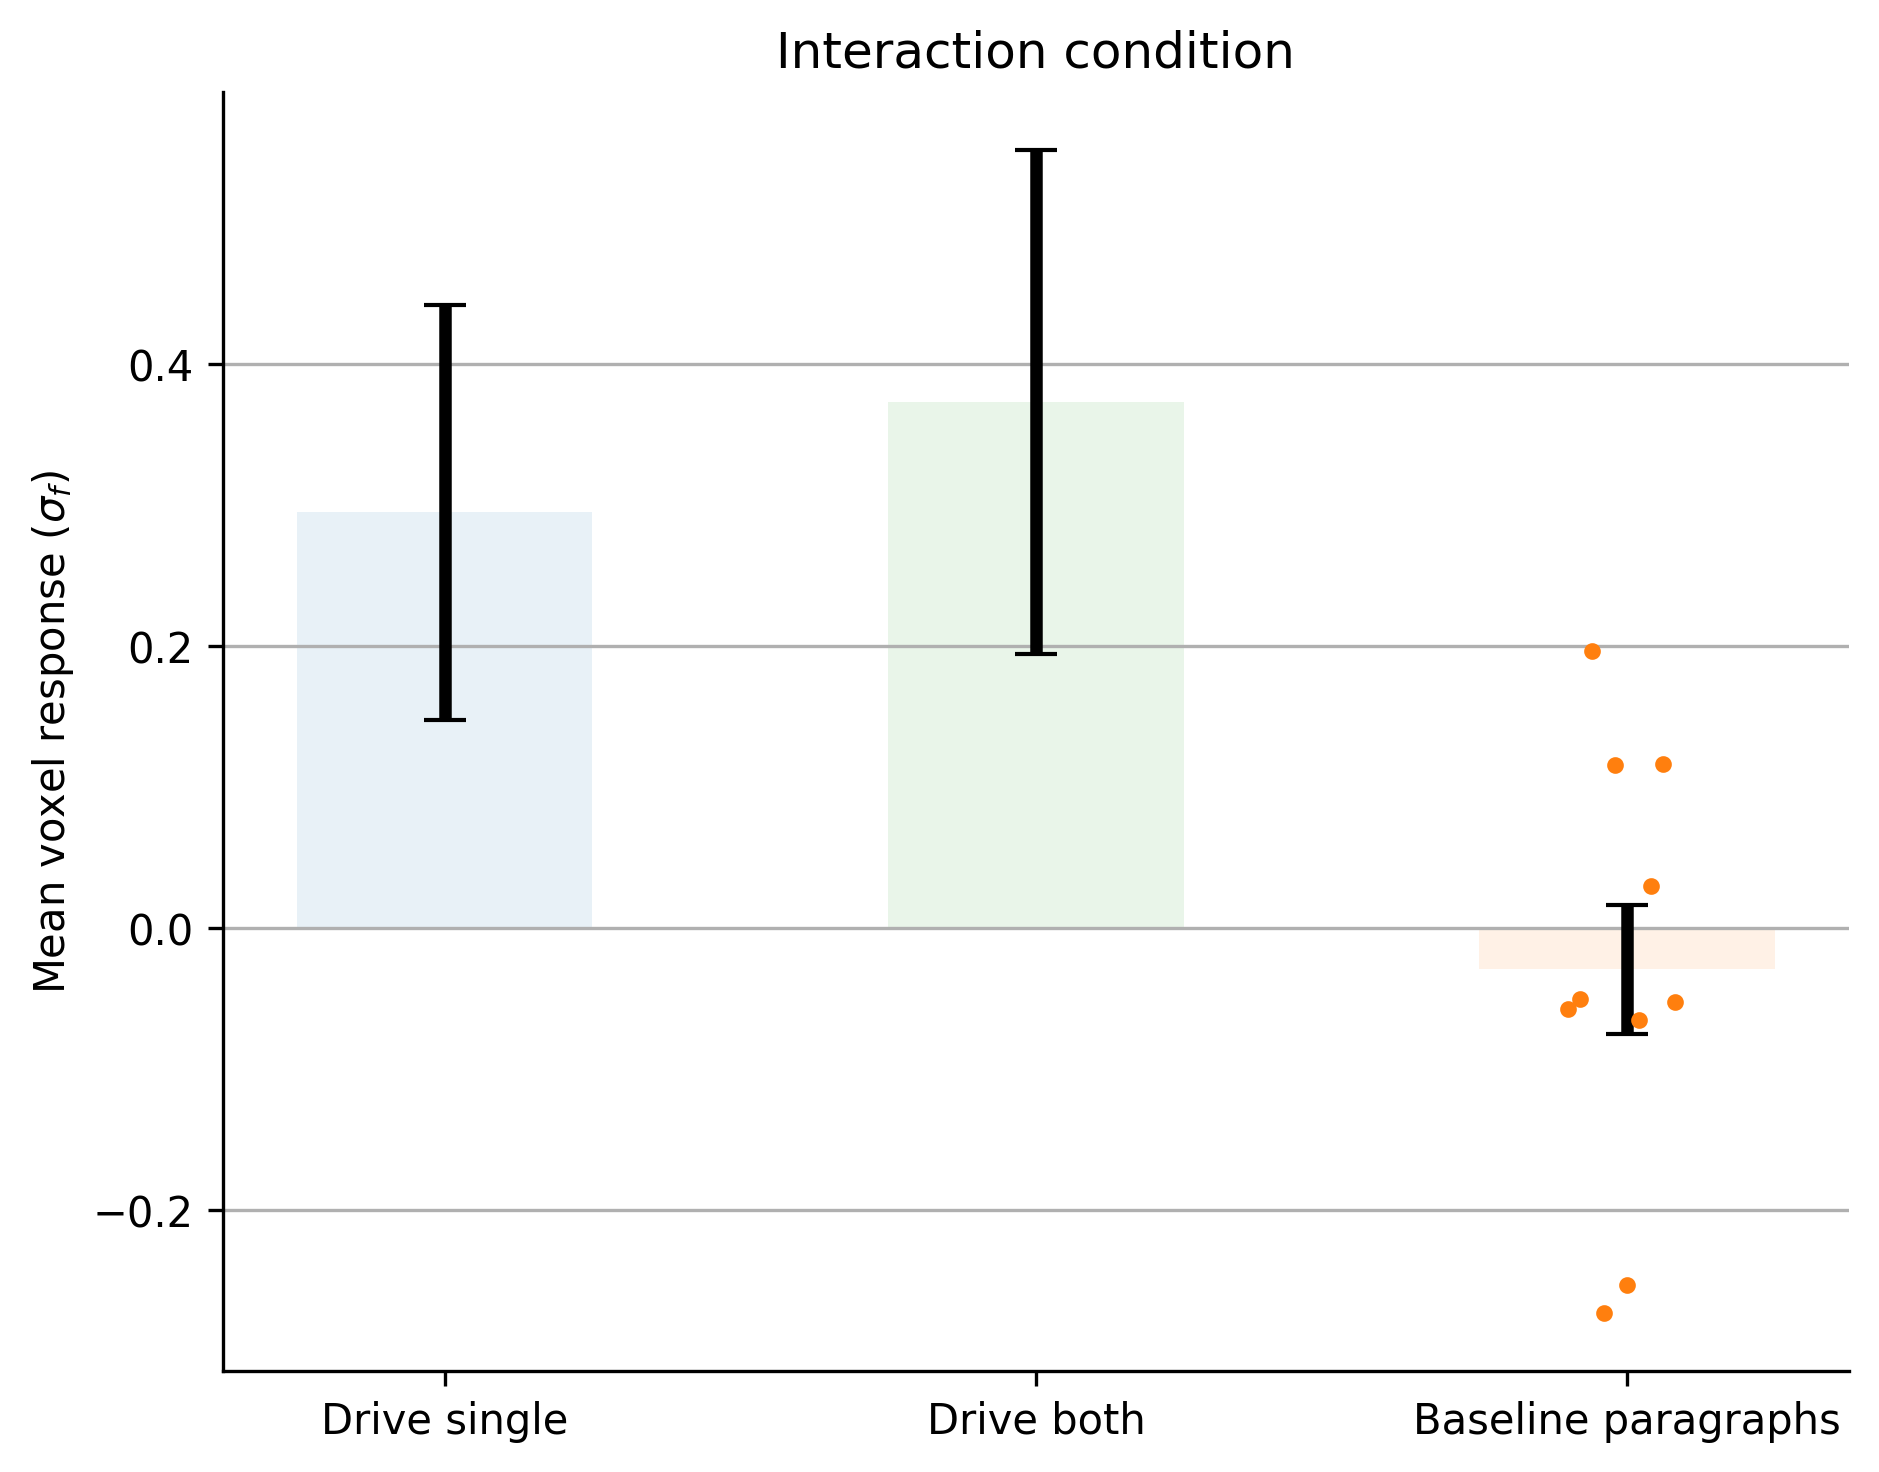

In [73]:
# calculate means
# use_clusters = False
# m1 = m[use_clusters]
m1 = mat_single

n = m1.shape[0]
diag_means = np.diag(m1)
diag_mean = np.nanmean(diag_means)

# get mean of each row excluding the diagonal
off_diag_means = np.nanmean(m1, axis=1) - (diag_means / n)
off_diag_mean = np.nanmean(off_diag_means)

# make plot
plt.figure(dpi=300)
x = np.arange(n) - n / 2
plt.bar(0, diag_mean, width=0.5, label='Diagonal', alpha=0.1, color='C0')
plt.errorbar(0, diag_mean, yerr=np.nanstd(diag_means) / np.sqrt(len(diag_means)), fmt='.', label='Diagonal', ms=0, color='black', elinewidth=3, capsize=5, lw=1)

plt.bar(2, off_diag_mean, width=0.5, label='Off-diagonal', alpha=0.1, color='C1')
plt.errorbar(2, off_diag_mean, yerr=np.nanstd(off_diag_means) / np.sqrt(len(off_diag_means)), fmt='.', label='Diagonal', ms=0, color='black', elinewidth=3, capsize=5)
plt.plot(2 + x/50, off_diag_means, '.', color='C1')




m1 = mat_inter


n = m1.shape[0]
diag_means = np.diag(m1)
diag_mean = np.nanmean(diag_means)

# get mean of each row excluding the diagonal
off_diag_means = np.nanmean(m1, axis=1) - (diag_means / n)
off_diag_mean = np.nanmean(off_diag_means)

# make plot
x = np.arange(n) - n / 2
plt.bar(1, diag_mean, width=0.5, label='Diagonal', alpha=0.1, color='C2')
plt.errorbar(1, diag_mean, yerr=np.nanstd(diag_means) / np.sqrt(len(diag_means)), fmt='.', label='Diagonal', ms=0, color='black', elinewidth=3, capsize=5, lw=1)



plt.xticks([0, 1, 2], ['Drive single', 'Drive both', 'Baseline paragraphs'])
plt.ylabel('Mean voxel response ($\sigma_f$)')
plt.grid(axis='y')

plt.tight_layout()
print('mean', diag_mean - off_diag_mean)
print('median', np.nanmedian(diag_means) - np.nanmedian(off_diag_means))
plt.title('Interaction condition')
# plt.title(f'use_clusters={use_clusters}')
plt.savefig(join(RESULTS_DIR, 'pilot_interaction_means.pdf'))

### Relationship between different voxels

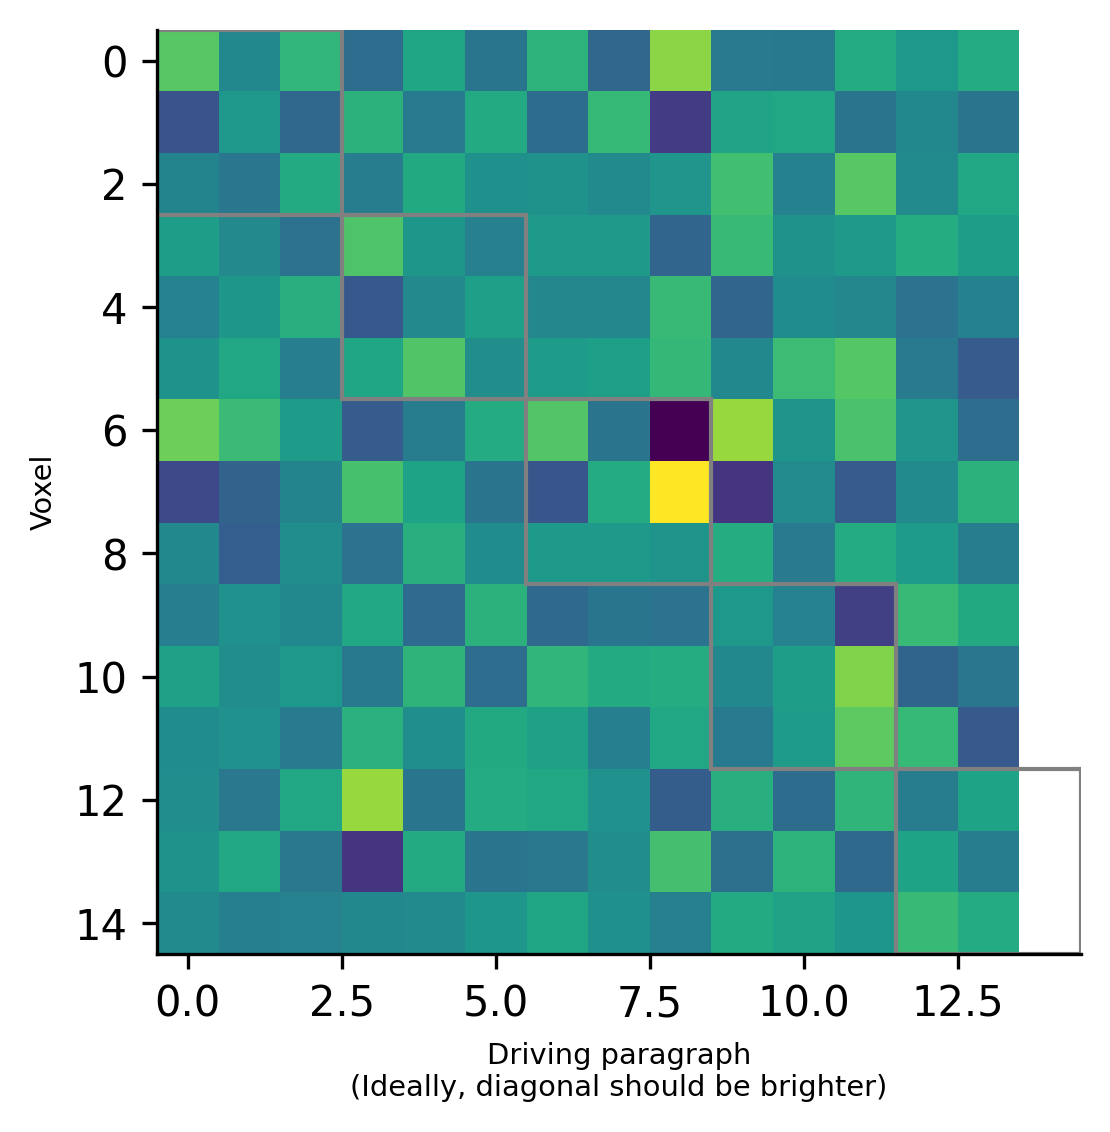

In [74]:
# note: some voxels didn't have good clusters so they will be missing from these plots...
# use_clusters = False
# m1 = m[use_clusters]
m1 = mat_out
# cg = sns.clustermap(pd.DataFrame(m, columns=expls, index=expls), method='complete', cmap='viridis', figsize=(10, 10))
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# plt.xlabel('Driving paragraph')
plt.figure(figsize=(12, 4), dpi=300)
# m = softmax(m, axis=0)


for r in range(m1.shape[0]):
    for c in range(m1.shape[1]):
        # outline the diagonal with blocksize 1
        # if r == c:
        #     plt.plot([r - 0.5, r + 0.5], [c - 0.5, c - 0.5], color="gray", lw=1)
        #     plt.plot([r - 0.5, r + 0.5], [c + 0.5, c + 0.5], color="gray", lw=1)
        #     plt.plot([r - 0.5, r - 0.5], [c - 0.5, c + 0.5], color="gray", lw=1)
        #     plt.plot([r + 0.5, r + 0.5], [c - 0.5, c + 0.5], color="gray", lw=1)
        # outline the diagonal with blocksize 2
        # if r == c and r % 2 == 0:
        #     rx = r + 0.5
        #     cx = c + 0.5
        #     plt.plot([rx - 1, rx + 1], [cx - 1, cx - 1], color="gray", lw=1)
        #     plt.plot([rx - 1, rx + 1], [cx + 1, cx + 1], color="gray", lw=1)
        #     plt.plot([rx - 1, rx - 1], [cx - 1, cx + 1], color="gray", lw=1)
        #     plt.plot([rx + 1, rx + 1], [cx - 1, cx + 1], color="gray", lw=1)
        # outline the diagonal with blocksize 3
        if r == c and r % 3 == 0:
            rx = r + 1
            cx = c + 1
            plt.plot([rx - 1.5, rx + 1.5], [cx - 1.5, cx - 1.5], color="gray", lw=1)
            plt.plot([rx - 1.5, rx + 1.5], [cx + 1.5, cx + 1.5], color="gray", lw=1)
            plt.plot([rx - 1.5, rx - 1.5], [cx - 1.5, cx + 1.5], color="gray", lw=1)
            plt.plot([rx + 1.5, rx + 1.5], [cx - 1.5, cx + 1.5], color="gray", lw=1)
        


# expls_order = analyze_helper.sort_expls_semantically(expls)
# expls_order = np.arange(len(expls))
m_plot = m1
# m_plot = m1[expls_order][:, expls_order]  # [:, expls_order]
# m_plot = m1
plt.imshow(m_plot)
plt.xlabel(
    "Driving paragraph\n(Ideally, diagonal should be brighter)", fontsize="x-small"
)
plt.ylabel("Voxel", fontsize="x-small")
vox_names = []
for i in range(0, len(rows), 2):
    vox_names.append(
        "Vox "
        + str(rows["module_num"].values[i])
        + "\n("
        + rows["expl"].values[i]
        + ' & ' + rows["expl"].values[i + 1]
        + ")"
    )
# plt.yticks(labels=expls_with_num.values[expls_order], ticks=np.arange(len(expls)), fontsize='x-small')
# plt.yticks(labels=vox_names, ticks=0.5 + np.arange(len(vox_names)) * 2, fontsize="x-small")
# plt.xticks(
#     labels=expls[expls_order],
#     ticks=np.arange(len(expls)),
#     rotation=90,
#     fontsize="x-small",
# )
plt.show()

# plot correlations across all resps
# resps_voxels = np.concatenate(
#     [resps_dict[story_data["story_name_new"][story_num]].T for story_num in [2, 3, 4]],
#     axis=1,
# )[rw["voxel_num"].values]
# corr = pd.DataFrame(resps_voxels.T, columns=expls).corr().round(2)
# sns.clustermap(corr)

### Story-level differences

In [ ]:
use_clusters = False
mats1 = mats[use_clusters]

d = defaultdict(list)
for i in range(len(mats1)):
    m = mats1[i]
    d['driving'].append(np.nanmean(np.diag(m)))
    d['baseline'].append(np.nanmean(m[~np.eye(m.shape[0], dtype=bool)]))
    d['story'].append(story_data['story_name_new'][i][3:-10])

df = pd.DataFrame.from_dict(d)

# make barplot comparing driving and baseline
df = df.melt(id_vars='story', value_vars=['driving', 'baseline'], var_name='condition', value_name='mean')
df = df.sort_values(by='story')
plt.figure(dpi=300)
sns.barplot(data=df, x='story', y='mean', hue='condition')
plt.ylabel('Mean voxel response ($\sigma_f$)')
plt.show()